# Analisis del conteo de las actas basado en OCR

El presente notebook tiene como fin analisar los resultados generados por el algoritmo de OCR.
Para mas informacion de como funciona el OCR, dirigirse a su respectivo Notebook.



Los datos presentados por el OCR estan distrubidos de esta manera.

El total de actas descargadas es de 33068 hasta el dia 22 de octubre que estaban disponibles para descargar.

60% (aprox 19000 actas) de las actas descargadas hasta el martes 22 de octubre fueron analizadas sin ningun preprocesamiento, es decir, se la presento al algiritmo de OCR y este pudo extraer los campos de los partidos politicos (en total 24)  sin ningun problema.

15% (aprox 5000 estas) requirieron un preprosesamiento simple para obtener las regiones de los partidos politicos.


Existiran dos analisis, el primero que se presenta a continuacion es sobre el primer conjundo del 60%.



## Analisis al 60%

Se tiene acceso al csv de los datos generados por el algoritmo de OCR el dia 3 de noviembre, donde inmediatamente se empieza a realizar los siguientes analisis.

**Cargar las actas computadas (predicciones)**

Se procede a revisar la carpeta donde estan los datos

In [5]:
%ls ../actas-de-mesa/results/

detect_boxes_error_log.txt  errorInOpenFile.txt  preds/  results_log.txt


Existen tres archivos generados.
* _detect_boxes_error_log.txt_ se reviere al restante 40% que no pudo ser analisado por el OCR en una primera fase.
* _errorInOpenFile.txt_, es la lista de imagenes corruptas o que no se pudieron abrir.
* _results_log.txt_, es el computo realizado, son los 60% de datos computados.


Aqui una muestra de las imagenes analizadas dentro del directorio de trabajo

In [2]:
%ls ../actas-de-mesa/actas/cuts/

100011.jpg  231831.jpg  287471.jpg  352571.jpg  611971.jpg  748531.jpg
100021.jpg  231841.jpg  287481.jpg  352581.jpg  611981.jpg  748541.jpg
100031.jpg  231851.jpg  287491.jpg  352591.jpg  611991.jpg  748551.jpg
100041.jpg  231861.jpg  287501.jpg  352601.jpg  612001.jpg  748561.jpg
100051.jpg  231871.jpg  287511.jpg  352611.jpg  612011.jpg  748571.jpg
100061.jpg  231881.jpg  287521.jpg  352621.jpg  612021.jpg  748581.jpg
100071.jpg  231891.jpg  287531.jpg  352631.jpg  612031.jpg  748591.jpg
100081.jpg  231901.jpg  287541.jpg  352641.jpg  612041.jpg  748601.jpg
100091.jpg  231911.jpg  287551.jpg  352651.jpg  612051.jpg  748611.jpg
100101.jpg  23191.jpg   287561.jpg  352661.jpg  612061.jpg  748621.jpg
100111.jpg  231921.jpg  287571.jpg  352671.jpg  612071.jpg  748631.jpg
10011.jpg   231931.jpg  287581.jpg  352681.jpg  612081.jpg  748641.jpg
100121.jpg  231941.jpg  287591.jpg  352691.jpg  612091.jpg  748651.jpg
100131.jpg  231951.jpg  287601.jpg  352701.jpg  612101.jpg  748661.jpg
100141

100791.jpg  232601.jpg  288381.jpg  353411.jpg  612801.jpg  749361.jpg
100801.jpg  232611.jpg  288391.jpg  353421.jpg  612811.jpg  749371.jpg
100811.jpg  23261.jpg   288401.jpg  353431.jpg  612821.jpg  749381.jpg
10081.jpg   232621.jpg  288411.jpg  353441.jpg  612831.jpg  749391.jpg
100821.jpg  232631.jpg  288421.jpg  353451.jpg  612841.jpg  749401.jpg
100831.jpg  232641.jpg  288431.jpg  353461.jpg  612851.jpg  749411.jpg
100841.jpg  232651.jpg  288441.jpg  353471.jpg  612861.jpg  749421.jpg
100851.jpg  232661.jpg  288451.jpg  353481.jpg  612871.jpg  749431.jpg
100861.jpg  232671.jpg  288461.jpg  353491.jpg  612881.jpg  749441.jpg
100871.jpg  232681.jpg  288471.jpg  353501.jpg  612891.jpg  749451.jpg
100881.jpg  232691.jpg  288481.jpg  353511.jpg  612901.jpg  749461.jpg
100891.jpg  232701.jpg  288501.jpg  353521.jpg  612911.jpg  749471.jpg
100901.jpg  232711.jpg  288511.jpg  353531.jpg  612921.jpg  749481.jpg
100911.jpg  23271.jpg   288521.jpg  353541.jpg  612931.jpg  749491.jpg
100921

220341.jpg  274281.jpg  340781.jpg  600231.jpg  736901.jpg  805311.jpg
220351.jpg  274291.jpg  340791.jpg  600241.jpg  736911.jpg  805321.jpg
220361.jpg  274311.jpg  340801.jpg  600251.jpg  736921.jpg  805331.jpg
220371.jpg  274321.jpg  340811.jpg  600261.jpg  736931.jpg  805341.jpg
220381.jpg  274331.jpg  340821.jpg  600271.jpg  736941.jpg  805351.jpg
220391.jpg  274341.jpg  340831.jpg  600281.jpg  736951.jpg  805361.jpg
220401.jpg  274351.jpg  340841.jpg  600291.jpg  736961.jpg  805371.jpg
220411.jpg  274361.jpg  340851.jpg  600301.jpg  736971.jpg  805381.jpg
22041.jpg   274371.jpg  340861.jpg  600311.jpg  736981.jpg  805391.jpg
220421.jpg  274381.jpg  340871.jpg  600321.jpg  736991.jpg  805401.jpg
220431.jpg  274391.jpg  340881.jpg  600331.jpg  737001.jpg  805411.jpg
220441.jpg  274401.jpg  340891.jpg  600341.jpg  737011.jpg  805421.jpg
220451.jpg  274411.jpg  340901.jpg  600351.jpg  737021.jpg  805431.jpg
220461.jpg  274421.jpg  340911.jpg  600361.jpg  737031.jpg  805441.jpg
220471

In [1]:
# definir la ruta a los datos

path_data = "../actas-de-mesa/results/results_log.txt"

path_imgs = "../actas-de-mesa/actas/cuts/"

**Importar algunas librerias**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from skimage.transform import resize
from scipy import ndimage
import cv2
import math
import random

import seaborn as sns
sns.set(color_codes=True)

%matplotlib inline

In [3]:
# Libreria custom
from libs import utils 


In [4]:
# Custom function
def show_image(file_name, full=False):
    img = cv2.imread(file_name)
    plt.figure(figsize=(10,10))
    plt.imshow(img)

**Cargar las rutas a las imagenes calculadas**

_Nota: Al momento en el que se realiza este analisi, se esta procesando la muestra del 15%_
Vamos a cargar una muestra aleatoria de este conjunto.

In [5]:
actas_procesadas = glob.glob(path_imgs + "*.jpg")

print(f"¿Cuantas imagens procesadas?: {len(actas_procesadas)}")


¿Cuantas imagens procesadas?: 32461


**Muestra del calculo realizado en una acta**

La region de interes es la que rodea a los conteos para cada partido, se añadio un indice a cada partido, que va desde el 1 hasta el 24. A continuacion mostramos como 

../actas-de-mesa/actas/cuts/782981.jpg


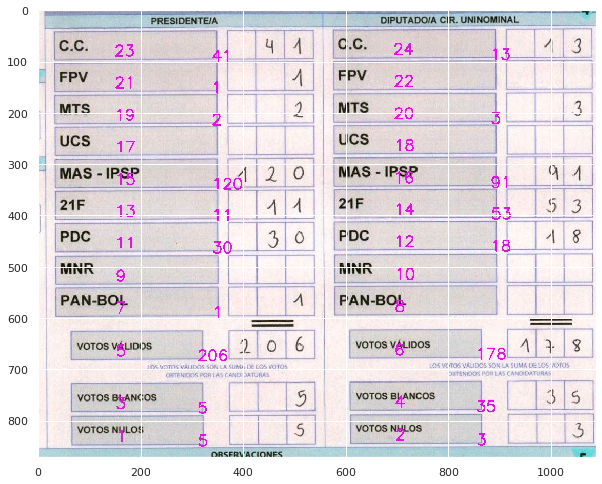

In [29]:
# Escojer una imagen aleatoria
index_random = random.randint(0, len(actas_procesadas))
image_random = actas_procesadas[index_random]
print(image_random)
show_image(image_random)

###  Carga de datos,  limpieza  y exploracion

In [77]:
# Combertir el csv en un dataframe

df = pd.read_csv(path_data, names=["id", "counts", "partidoid"])
print(df.shape)
df.head()

(477866, 3)


,id,counts,partidoid
0,720391.jpg,7.0,1
1,720391.jpg,5.0,2
2,720391.jpg,4.0,3
3,720391.jpg,22.0,4
4,720391.jpg,187.0,5


Existen 468343 campos calculados, es decir de cada acta salen 24 valores, correspondientes a los campos descritos arriba.


A continuacion veremos cuantas actas procesadas unicas existieron:

In [78]:
u_actas = np.unique(df["id"])
print(f"Actas unicas en total: {len(u_actas)}")

Actas unicas en total: 19958


Estas 19562, represetan el 60% de las actas procesadas del total.

#### Filtrando los campos del MAS y del CC, presidentes

Para el **MAS** el indice asignado es el **numero 15** y para **CC** es el **numero 23**

#### Dataframe para el CC, presidentes


Se ingresa al dataframe original y le decimos que solo quiero las filas que tengan el **_partidoId_** 23


In [79]:
df_cc = df[df["partidoid"] == 23]
df_cc.head()

,id,counts,partidoid
22,720391.jpg,99.0,23
46,721931.jpg,108.0,23
70,361011.jpg,12.0,23
94,267671.jpg,11.0,23
118,737881.jpg,89.0,23


Una suma rapida para ver el total de sus votos

In [80]:
cc_count = df_cc["counts"].sum()
print(cc_count)

1430387.0


Al parecer un conteo rapido nos dio un resultado de casi 1.3 M de votos.


Veamos la distrubucion de los votos.

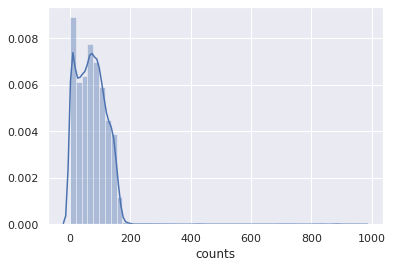

In [81]:
# Quitamos los valores nulos
#df_cc = df_cc.dropna()

df_cc  = df_cc.fillna(0)

sns.distplot(df_cc["counts"]);

Existen outliers que pueden ser causados por la mala lectura de los digutos y estos fueron convertidos a numeros muy grandes.
Vamos a quitar los valores mayores  a 250, ya que segun se observo, no suelen existir mesas con votantes mayores a 250.

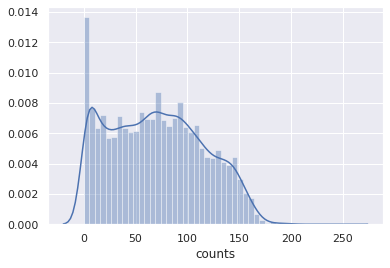

In [83]:
# Filtrar los datos que sean menores a 250
df_cc_f = df_cc[df_cc["counts"]< 300]


# Grafica de la distribucion de los votos por mesa
sns.distplot(df_cc_f["counts"]);

La grafica se empieza a asemejar mucho a la grafia presentada por el comput oficial. 
Recalculemos la suma final.

In [84]:
suma_final = df_cc_f["counts"].sum()
print(f"SUMA FINAL: {suma_final}")

SUMA FINAL: 1412975.0


#### Dataframe para el MAS, presidentes


In [85]:
df_mas = df[df["partidoid"] == 15]
df_mas.head()

,id,counts,partidoid
14,720391.jpg,63.0,15
39,721931.jpg,39.0,15
62,361011.jpg,160.0,15
86,267671.jpg,110.0,15
110,737881.jpg,66.0,15


In [86]:
# Suma rapida
mas_count = df_mas["counts"].sum()
print(mas_count)

1546494.0


Repetimos los pasados calculos

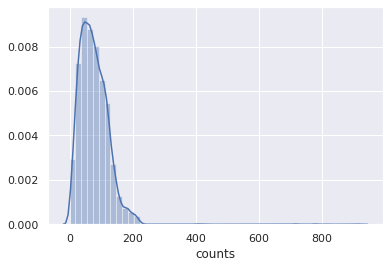

In [87]:
# Quitamos los valores nulos
#df_mas = df_mas.dropna()
df_mas  = df_mas.fillna(0)

# Distribucion de los votos
sns.distplot(df_mas["counts"]);

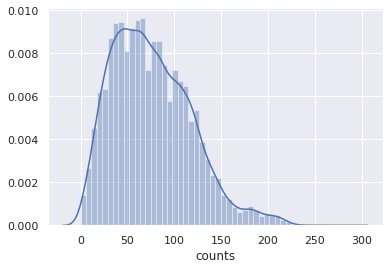

In [88]:
# Ditribucion corregida para los outliers

# Filtrar los datos que sean menores a 250
df_mas_f = df_mas[df_mas["counts"]< 300]

# Grafica de la distribucion de los votos por mesa
sns.distplot(df_mas_f["counts"]);

### Comparaciones con el computo oficial

**Carga de los datos en Excel**

Vamos a comparar estos votos con los que existen en el excel que esta disponible en la pagina Web de Computo.
https://computo.oep.org.bo/

Hasta el 5 de noviembre, este archivo es la ultima version oficial.

 https://computo.oep.org.bo/PubResul/acta.2019.10.25.21.09.30.xlsx

In [68]:
# Decargamos el archivo excel
!wget https://computo.oep.org.bo/PubResul/acta.2019.10.25.21.09.30.xlsx

--2019-11-05 19:04:44--  https://computo.oep.org.bo/PubResul/acta.2019.10.25.21.09.30.xlsx
Resolving computo.oep.org.bo (computo.oep.org.bo)... 104.20.195.42, 104.20.194.42, 2606:4700:10::6814:c22a, ...
Connecting to computo.oep.org.bo (computo.oep.org.bo)|104.20.195.42|:443... connected.
HTTP request sent, awaiting response... 200 
Length: unspecified [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘acta.2019.10.25.21.09.30.xlsx’

acta.2019.10.25.21.     [   <=>              ]   6,95M  14,9MB/s    in 0,5s    

2019-11-05 19:04:45 (14,9 MB/s) - ‘acta.2019.10.25.21.09.30.xlsx’ saved [7285922]



In [25]:
# Se descargo con el nombre 'acta.2019.10.25.21.09.30.xlsx'
%ls

 acta.2019.10.22.22.29.53.xlsx      'Handle 40%.ipynb'
 acta.2019.10.25.10.13.40.xlsx       libs/
'acta.2019.10.25.21.09.30(1).xlsx'   metadata_images_computo.csv
 acta.2019.10.25.21.09.30.xlsx       models/
 actas-an-extract-metadata.ipynb     montage.png
 badImagesList.np.npy                output/
'Data Analysis Counts-Copy1.ipynb'   Pixel_wise_ana.ipynb
'Data Analysis Counts.ipynb'         rawMetadata.np.npy
 dataset/                            results/
 dataset_2/                          test/
 dataset_p_actas.png                 test_custom_mnist_creation.ipynb
'Handle 40%-Copy1.ipynb'             train_reset.ipynb


In [26]:
# Excel oficial

path_excel = 'acta.2019.10.25.21.09.30.xlsx'

In [89]:
# Cargamos el Excel en un dataframe
df_x = pd.read_excel(path_excel)
print(df_x.shape)
df_x.head()

(68140, 26)


,País,Número departamento,Departamento,Provincia,Número municipio,Municipio,Circunscripción,Localidad,Recinto,Número Mesa,...,UCS,MAS - IPSP,21F,PDC,MNR,PAN-BOL,Votos Válidos,Blancos,Nulos,Estado acta
0,Argentina,10,Buenos Aires,Quilmes,1,Quilmes,NaN,Ezpeleta,Esc Primaria Nro 52 Gral. Bartolome Mitre.,1455,...,0,118,0,3,1,2,126,1,1,Computada
1,Argentina,10,Buenos Aires,Quilmes,1,Quilmes,NaN,Ezpeleta,Esc Primaria Nro 52 Gral. Bartolome Mitre.,1456,...,0,110,0,5,1,1,125,1,6,Computada
2,Argentina,10,Buenos Aires,Quilmes,1,Quilmes,NaN,Ezpeleta,Esc Primaria Nro 52 Gral. Bartolome Mitre.,1457,...,1,120,2,3,0,0,131,1,5,Computada
3,Argentina,10,Buenos Aires,Quilmes,1,Quilmes,NaN,Ezpeleta,Esc Primaria Nro 52 Gral. Bartolome Mitre.,1458,...,1,124,0,2,0,2,139,2,2,Computada
4,Argentina,10,Buenos Aires,Quilmes,1,Quilmes,NaN,Ezpeleta,Esc Primaria Nro 52 Gral. Bartolome Mitre.,1459,...,0,122,0,6,0,0,136,1,2,Computada


Existen 68140 filas y  26 columnas

In [95]:
# Mostrar nombres de columans
df_x.columns

Index(['País', 'Número departamento', 'Departamento', 'Provincia',
       'Número municipio', 'Municipio', 'Circunscripción', 'Localidad',
       'Recinto', 'Número Mesa', 'Código Mesa', 'Elección', 'Inscritos', 'CC',
       'FPV', 'MTS', 'UCS', 'MAS - IPSP', '21F', 'PDC', 'MNR', 'PAN-BOL',
       'Votos Válidos', 'Blancos', 'Nulos', 'Estado acta'],
      dtype='object')

In [91]:
# Filtrar solo las filas que son para presidentes.

# delete diputados
df_x = df_x[df_x["Elección"] == "Presidente y Vicepresidente"]
print(df_x.shape)
df_x.head()

(34555, 26)


,País,Número departamento,Departamento,Provincia,Número municipio,Municipio,Circunscripción,Localidad,Recinto,Número Mesa,...,UCS,MAS - IPSP,21F,PDC,MNR,PAN-BOL,Votos Válidos,Blancos,Nulos,Estado acta
0,Argentina,10,Buenos Aires,Quilmes,1,Quilmes,NaN,Ezpeleta,Esc Primaria Nro 52 Gral. Bartolome Mitre.,1455,...,0,118,0,3,1,2,126,1,1,Computada
1,Argentina,10,Buenos Aires,Quilmes,1,Quilmes,NaN,Ezpeleta,Esc Primaria Nro 52 Gral. Bartolome Mitre.,1456,...,0,110,0,5,1,1,125,1,6,Computada
2,Argentina,10,Buenos Aires,Quilmes,1,Quilmes,NaN,Ezpeleta,Esc Primaria Nro 52 Gral. Bartolome Mitre.,1457,...,1,120,2,3,0,0,131,1,5,Computada
3,Argentina,10,Buenos Aires,Quilmes,1,Quilmes,NaN,Ezpeleta,Esc Primaria Nro 52 Gral. Bartolome Mitre.,1458,...,1,124,0,2,0,2,139,2,2,Computada
4,Argentina,10,Buenos Aires,Quilmes,1,Quilmes,NaN,Ezpeleta,Esc Primaria Nro 52 Gral. Bartolome Mitre.,1459,...,0,122,0,6,0,0,136,1,2,Computada


EL dataframe se redujo a 34555 filas.

### Contrastar las predicciones con los datos oficiales

Vamos a comparar los datos que vienen de las predicciones del OCR  con los datos oficiales.

Empezaremos con Comunidad Ciudadana, CC.

### CC

In [96]:
# Un vistaso rapido al dataframe predecido para CC

df_cc.head()

,id,counts,partidoid,mesa
22,720391.jpg,99.0,23,72039
46,721931.jpg,108.0,23,72193
70,361011.jpg,12.0,23,36101
94,267671.jpg,11.0,23,26767
118,737881.jpg,89.0,23,73788


In [97]:
# Tamaño de este dataframe
df_cc.shape

(20072, 4)

Crear una nueva columna para extraer el id original de la mesa, esta contenida dentro  de las filas de la columna "id".

In [98]:
# Extract mesa id column 

def label_race(row):
    """
    Funcion auxiliar para sacar el id original.
    
    Inputs:
        row is a generic pandas row.
    returns:
        String with the original id
    """
    
    # Get the string.jpg
    
    name = row["id"]
    
    # Split jpg name, slice and select the id
    return name.split(".")[0][:-1]

# Crear una nueva columna para contener el id extraido

df_cc["mesa"] = df_cc.apply (lambda row: label_race(row), axis=1)
df_cc.head()

,id,counts,partidoid,mesa
22,720391.jpg,99.0,23,72039
46,721931.jpg,108.0,23,72193
70,361011.jpg,12.0,23,36101
94,267671.jpg,11.0,23,26767
118,737881.jpg,89.0,23,73788


Extraer los ids unicos para este nuevo dataframe df_cc y tambien para el df_x que es el oficial

In [99]:
uniques_cc = np.unique(list(df_cc["mesa"]))
uniques_excel = list(np.unique(df_x["Número Mesa"]))

print(f"Cuantos unicos para CC nuestro ? {len(uniques_cc)}")
print(f"Cuantos unicos para CC oficial ? {len(uniques_excel)}")

print(f"Fraccion {len(uniques_cc)}/{len(uniques_excel)} = {len(uniques_cc)/len(uniques_excel)}")

Cuantos unicos para CC nuestro ? 19863
Cuantos unicos para CC oficial ? 34555
Fraccion 19863/34555 = 0.5748227463464043


El ultimo dato es la fraccion de actas que tenemos computadas.

Vamos a calcular los ids de nuestro CC **que NO estan presentes** en la lista oficial de CC. 
Para esto creamos la siguiente clase auxiliar.

In [100]:
# Funcion auxiliar para buscar elementos que existen en una lista desde otra lista.
# Basado en binary search

from bisect import bisect_left

class Search:
    def __init__(self):
        pass
    
    def my_search(self, alist, item):
        'Locate the leftmost value exactly equal to item'
        i = bisect_left(alist, item)
        if i != len(alist) and alist[i] == item:
            return True
        else:
            return False

        raise ValueError
        
    def __call__(self, search_in = [], query_search = [] ):
        """
        Search if element in uniques_partido is in uniques_excel, if so, append
        """
        not_in = []
        
        alist = search_in
        
        alist.sort() # bisect only works on sorted lists

        for u in query_search:
            x = int(u)
            if self.my_search(list(alist), x):
                pass
            else:
                not_in.append(u)
                
        return not_in

search = Search()

In [101]:
# LE pasamos nuestra de excel y nuestra lista que tenemos para cc

not_in_oficial = search(search_in = uniques_excel, 
                query_search = uniques_cc)

print(f"Cuantos de mis IDS de CC NO ESTAN en el Oficial: {len(not_in_oficial)}")


Cuantos de mis IDS de CC NO ESTAN en el Oficial: 0


Parece que todos mis IDS para CC estan presentes en la lista oficial.

Con esta confirmacion vamos a sacar a todos estos IDs de la tabla oficial de Excel.
Vamos a crear una lista y volver a integer a los ids (codigo de mesa) que confirmamos que estan presentes en el excel oficial

In [107]:
mesas_cc = [int(m) for m in uniques_cc ]
print(len(mesas_cc ))

19863


In [103]:
# Filtrar el excel oficial solo con estas mesas que tenemos confirmados.

df_x_f  = df_x[df_x["Número Mesa"].isin(mesas_cc) ]

print(f"Tamaño {df_x_f.shape}")

df_x_f.head()

Tamaño (19863, 26)


,País,Número departamento,Departamento,Provincia,Número municipio,Municipio,Circunscripción,Localidad,Recinto,Número Mesa,...,UCS,MAS - IPSP,21F,PDC,MNR,PAN-BOL,Votos Válidos,Blancos,Nulos,Estado acta
261,Bolivia,1,Chuquisaca,Oropeza,1,Sucre,NaN,Arabate,Escuela Arabate,10001,...,0,79,1,0,0,0,82,6,11,Computada
263,Bolivia,1,Chuquisaca,Oropeza,1,Sucre,NaN,Chaunaca,Escuela Seccional De Chaunaca,10002,...,2,135,3,11,1,1,171,6,12,Computada
267,Bolivia,1,Chuquisaca,Oropeza,1,Sucre,NaN,Chuqui Chuqui,Unidad Educativa Chuqui Chuqui,10004,...,2,118,3,11,2,0,168,11,13,Computada
269,Bolivia,1,Chuquisaca,Oropeza,1,Sucre,NaN,Chuqui Chuqui,Unidad Educativa Chuqui Chuqui,10005,...,1,118,6,15,0,0,172,13,5,Computada
271,Bolivia,1,Chuquisaca,Oropeza,1,Sucre,NaN,Chuqui Chuqui,Unidad Educativa Chuqui Chuqui,10006,...,0,74,5,8,0,1,106,7,2,Computada


In [115]:
uniques_cc

array(['10001', '10002', '10004', ..., '90386', '90387', '90388'],
      dtype='<U5')

In [139]:
m = set(list(df_x_f["Número Mesa"].astype(int)))
d = set(list([int(u) for u in uniques_cc]))

diff = m.intersection(d)


len(diff)

19863

In [127]:
print(len(m))
print(len(d))

19863
19863


Con este dataframe oficial y el nuestro dataframe, vamos a comparar en cuales tubimos problemas para reconocer los numeros

### Filtrar los mal clasificados

Primero vamos a crear una lista con los valores de conteo, tanto para el excel oficial (filtrado) y para nuestro CC.

In [99]:
"""
counts_cc = [int(c) for c in list(df_cc["counts"])]
counts_excel_cc = [int(c) for c in list(df_x_f["CC"])]

# mostrar los tamaños de las listas de estos conteos
print(len(counts_cc))
print(len(counts_excel_cc))
"""

19232
19232


Vamos a ver ahora que valores nuestros, no estan presentes en la lista oficial, de nuevo utilizamos nuestro metodo auxiliar.

In [103]:
"""
not_in_excel_counts = search(search_in = counts_excel_cc, 
                            query_search = counts_cc)

print(f"Cuantos valores mios no existen en el oficial?: {len(np.unique(not_in_excel_counts))}")
"""

Cuantos valores mios no existen en el oficial?: 56


Ordenamos el dataframe excel

In [128]:
df_x_f = df_x_f.sort_values(by='Número Mesa', ascending=False)
df_x_f.head()

,País,Número departamento,Departamento,Provincia,Número municipio,Municipio,Circunscripción,Localidad,Recinto,Número Mesa,...,UCS,MAS - IPSP,21F,PDC,MNR,PAN-BOL,Votos Válidos,Blancos,Nulos,Estado acta
0,Bolivia,9,Pando,Federico Román,3,Santos Mercado,NaN,Villa Victoria,U.E. 11 de Septiembre,90388,...,1,83,4,2,0,0,153,4,4,Computada
1,Bolivia,9,Pando,Federico Román,3,Santos Mercado,NaN,San Martin del Pacahuara,U.E. 23 de Marzo,90387,...,1,33,7,5,0,1,73,1,3,Computada
2,Bolivia,9,Pando,Federico Román,3,Santos Mercado,NaN,San Martin del Pacahuara,U.E. 23 de Marzo,90386,...,1,57,9,8,1,1,170,3,19,Computada
3,Bolivia,9,Pando,Federico Román,3,Santos Mercado,NaN,San Martin del Pacahuara,U.E. 23 de Marzo,90385,...,1,74,9,3,2,0,182,3,10,Computada
4,Bolivia,9,Pando,Federico Román,3,Santos Mercado,NaN,Reserva,19 de Octubre,90384,...,1,15,4,4,0,0,42,0,2,Computada


In [129]:
# Quitamos los indices y los seteamos de nuevo desde cero en el orden de arriba

df_x_f = df_x_f.reset_index(drop=True)
df_x_f.head()

,País,Número departamento,Departamento,Provincia,Número municipio,Municipio,Circunscripción,Localidad,Recinto,Número Mesa,...,UCS,MAS - IPSP,21F,PDC,MNR,PAN-BOL,Votos Válidos,Blancos,Nulos,Estado acta
0,Bolivia,9,Pando,Federico Román,3,Santos Mercado,NaN,Villa Victoria,U.E. 11 de Septiembre,90388,...,1,83,4,2,0,0,153,4,4,Computada
1,Bolivia,9,Pando,Federico Román,3,Santos Mercado,NaN,San Martin del Pacahuara,U.E. 23 de Marzo,90387,...,1,33,7,5,0,1,73,1,3,Computada
2,Bolivia,9,Pando,Federico Román,3,Santos Mercado,NaN,San Martin del Pacahuara,U.E. 23 de Marzo,90386,...,1,57,9,8,1,1,170,3,19,Computada
3,Bolivia,9,Pando,Federico Román,3,Santos Mercado,NaN,San Martin del Pacahuara,U.E. 23 de Marzo,90385,...,1,74,9,3,2,0,182,3,10,Computada
4,Bolivia,9,Pando,Federico Román,3,Santos Mercado,NaN,Reserva,19 de Octubre,90384,...,1,15,4,4,0,0,42,0,2,Computada


In [130]:
df_x_f.shape

(19863, 26)

Ordenar el dataframe predicted para CC en base a la columna "mesa"

In [131]:
# De nuevo ordenamos el dataframe esta vez para CC, nuestras prediciones.

df_cc = df_cc.sort_values(by='mesa', ascending=False)
df_cc.head()

,id,counts,partidoid,mesa
46554,903881.jpg,60.0,23,90388
320855,903871.jpg,124.0,23,90387
320854,903871.jpg,19.0,23,90387
392812,903861.jpg,92.0,23,90386
343737,903851.jpg,91.0,23,90385


In [132]:
df_cc.shape

(20072, 4)

In [133]:
df_cc = df_cc.reset_index(drop=True)
df_cc.head()

,id,counts,partidoid,mesa
0,903881.jpg,60.0,23,90388
1,903871.jpg,124.0,23,90387
2,903871.jpg,19.0,23,90387
3,903861.jpg,92.0,23,90386
4,903851.jpg,91.0,23,90385


In [142]:
m = list(np.unique(list(df_x_f["Número Mesa"].astype(int))))


In [143]:
back= []
for man in m:
    back.append({man: m.count(man)})

In [146]:
back[:-20]

[{10001: 1},
 {10002: 1},
 {10004: 1},
 {10005: 1},
 {10006: 1},
 {10007: 1},
 {10008: 1},
 {10009: 1},
 {10010: 1},
 {10011: 1},
 {10012: 1},
 {10013: 1},
 {10014: 1},
 {10015: 1},
 {10016: 1},
 {10017: 1},
 {10018: 1},
 {10019: 1},
 {10020: 1},
 {10021: 1},
 {10022: 1},
 {10023: 1},
 {10024: 1},
 {10026: 1},
 {10027: 1},
 {10028: 1},
 {10029: 1},
 {10030: 1},
 {10031: 1},
 {10032: 1},
 {10033: 1},
 {10034: 1},
 {10035: 1},
 {10036: 1},
 {10037: 1},
 {10038: 1},
 {10039: 1},
 {10040: 1},
 {10041: 1},
 {10043: 1},
 {10044: 1},
 {10045: 1},
 {10046: 1},
 {10048: 1},
 {10050: 1},
 {10051: 1},
 {10052: 1},
 {10053: 1},
 {10055: 1},
 {10056: 1},
 {10057: 1},
 {10058: 1},
 {10059: 1},
 {10060: 1},
 {10062: 1},
 {10063: 1},
 {10064: 1},
 {10065: 1},
 {10066: 1},
 {10068: 1},
 {10069: 1},
 {10070: 1},
 {10071: 1},
 {10072: 1},
 {10073: 1},
 {10074: 1},
 {10075: 1},
 {10076: 1},
 {10077: 1},
 {10078: 1},
 {10080: 1},
 {10081: 1},
 {10082: 1},
 {10083: 1},
 {10084: 1},
 {10085: 1},
 {10086: 1},

In [156]:
counts = []
for b in back:
    for k ,v in b.items():
        if v > 1:
            counts.append(b)
        
            

In [157]:
counts[:10]

[]

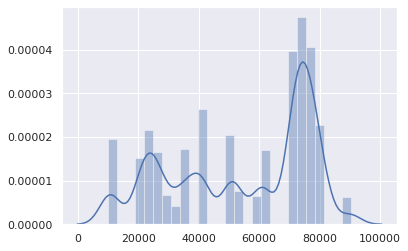

In [149]:

sns.distplot(m);

In [134]:
df_cc.shape

(20072, 4)

Ya que los dos estan alineados, es hora de comparar los votos de unos con otros

In [63]:
# Convertimos los valores de la columna counts de floats to int
df_cc["counts"] = df_cc["counts"].astype(int)

In [64]:
df_cc.head()

,id,counts,partidoid,mesa
0,903881.jpg,60,23,90388
1,903871.jpg,124,23,90387
2,903871.jpg,19,23,90387
3,903861.jpg,92,23,90386
4,903851.jpg,91,23,90385


In [73]:
df_x_f.shape

(19863, 26)

In [ ]:
df2.sort_index(inplace=True)

In [65]:
# Creamos una nueva columna en el archivo excel con los matches

df_x_f['match?'] = np.where(df_cc.counts == df_x_f['CC'], True, False)
df_x_f.head()

ValueError: Can only compare identically-labeled Series objects

In [52]:
# Nueva columan con los counts predicted desde CC

df_x_f["predicted"] = df_cc.counts

In [53]:
df_x_f.head()

,País,Número departamento,Departamento,Provincia,Número municipio,Municipio,Circunscripción,Localidad,Recinto,Número Mesa,...,21F,PDC,MNR,PAN-BOL,Votos Válidos,Blancos,Nulos,Estado acta,match?,predicted
0,Bolivia,9,Pando,Federico Román,3,Santos Mercado,NaN,Villa Victoria,U.E. 11 de Septiembre,90388,...,4,2,0,0,153,4,4,Computada,False,0
1,Bolivia,9,Pando,Federico Román,3,Santos Mercado,NaN,San Martin del Pacahuara,U.E. 23 de Marzo,90387,...,7,5,0,1,73,1,3,Computada,False,19
2,Bolivia,9,Pando,Federico Román,3,Santos Mercado,NaN,San Martin del Pacahuara,U.E. 23 de Marzo,90386,...,9,8,1,1,170,3,19,Computada,False,66
3,Bolivia,9,Pando,Federico Román,3,Santos Mercado,NaN,San Martin del Pacahuara,U.E. 23 de Marzo,90385,...,9,3,2,0,182,3,10,Computada,False,59
4,Bolivia,9,Pando,Federico Román,3,Santos Mercado,NaN,Reserva,19 de Octubre,90384,...,4,4,0,0,42,0,2,Computada,False,16


In [54]:
# Crear nuevo datarme con estas cuatro siguientes columnaas 

df_predicted = df_x_f[["Número Mesa", 'predicted','CC', "match?"]]
df_predicted.head()

,Número Mesa,predicted,CC,match?
0,90388,0,60,False
1,90387,19,24,False
2,90386,66,92,False
3,90385,59,91,False
4,90384,16,18,False


In [55]:
df_predicted.shape

(19462, 4)

In [56]:
# Filtrar solo las columnas donde las predicciones y el real no coinciden
df_predicted_bad = df_predicted[df_predicted["match?"] == False]
df_predicted_bad.head()

,Número Mesa,predicted,CC,match?
0,90388,0,60,False
1,90387,19,24,False
2,90386,66,92,False
3,90385,59,91,False
4,90384,16,18,False


In [57]:
df_predicted_bad.shape

(2974, 4)

In [58]:
# REsetear los indices

df_predicted_bad = df_predicted_bad.reset_index(drop=True)
df_predicted_bad.head()

,Número Mesa,predicted,CC,match?
0,90388,0,60,False
1,90387,19,24,False
2,90386,66,92,False
3,90385,59,91,False
4,90384,16,18,False


In [60]:
# Aux functinos

P1 = (90*4, 98*4)
P2 = (272*4, 218*4)

font                   = cv2.FONT_HERSHEY_SIMPLEX
fontScale              = 1
fontColor              = (255,0,255)
lineType               = 2


def find_contour_base(image, kernel):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  

    #--- performing Otsu threshold ---
    ret,thresh1 = cv2.threshold(gray, 0, 255, 
                                cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
    #--- choosing the right kernel
    #--- kernel size of 3 rows (to join dots above letters 'i' and 'j')
    #--- and 10 columns to join neighboring letters in words and neighboring words
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel)
    dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)
    #---Finding contours ---
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    im2 = image.copy()

    return im2, contours
        
def find_contour(image, image_path=""):
    
    #(30, 2) for letters
    im2, contours = find_contour_base(image, (7,2))

    boxes = []
    outputs =[]

    # Iterate over all contours
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        p1 = (x, y)
        p2 = (x + w, y + h)

        deltax = p2[0]-p1[0]
        deltay = p2[1]-p1[1]

        if (200<=(deltax)<=360) and (30<=(deltay)<=70):
            # print(deltax)
            # print(deltay)
            p1 = (p1[0], p1[1])
            p2 = (p2[0] + 210*0, p2[1])

            boxes.append([p1,p2])

            cv2.rectangle(im2, p1, p2, (0, 255, 0), 2)

    size = len(boxes)
    #print(f"TOTAL BOXES {size}")

    # If all the rectanguler boxes was found.
    if size == 24:
        # print("size",size)

        # Iterate over the rectangular boxes
        for i, b in enumerate(boxes):

            partido_id = str(i+1)

            outputs.append({i+1: b})


            cv2.putText(im2, partido_id, tuple(b[0]), 
                                            font, 
                                            fontScale,
                                            fontColor,
                                            lineType)
    else:
        """
        If detection is < 24 log this file
        """
        file_name = "detect_boxes_error_log"
        print(f"ERROR BOxes {file_name} - {size}")
    return im2, outputs


def norm_image(image):
    """
    Norm image to constant shape
    """
    img = cv2.resize(image, (2500, 1600))
    return img

def cut_image(image, p1, p2, simple=False):
    """
    Crop any imagen given P1 and P2
    """
    x = p1[0]
    y = p1[1]

    w = p2[0]
    h = p2[1]

    if simple:
        crop_img = image[y:h, x:w]
    crop_img = image[y:y+h, x:x+w]
    return crop_img

def show_image(file_name, full=False):
    
    img = cv2.imread(file_name)
    
    if full:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img_r   =  norm_image(img)
        # extract only the votation box
        c_image =   cut_image(img_r, P1, P2)

        cont_img,  outputs = find_contour(c_image)

        plt.figure(figsize=(10,10))
        plt.imshow(cont_img)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10,10))
        plt.imshow(img)

In [61]:
images_bad = list(df_predicted_bad["Número Mesa"])
images_bad[:3]

[90388, 90387, 90386]

In [62]:
images_bad = ["/home/actas/" + str(im)+ "1.jpg"  for im in images_bad]
images_bad[:3]

['/home/actas/903881.jpg', '/home/actas/903871.jpg', '/home/actas/903861.jpg']

In [63]:
counter = 0
bads = []

def plot_image():
    global counter
    print(counter)
    P = df_predicted_bad["predicted"][counter]
    A = df_predicted_bad["CC"][counter]
    I = df_predicted_bad["Número Mesa"][counter]
    
    print("......")
    print(f"P: {P}")
    print(f"A: {A}")
    print(f"ID: {I}")
    print(f"LINK: {I}1.jpg")
    
    image = f"/home/actas/{I}1.jpg"

    show_image(image, full=True)

In [89]:
I = df_predicted_bad["Número Mesa"][622]
print(I)

78510


In [309]:
df_x.columns

Index(['País', 'Número departamento', 'Departamento', 'Provincia',
       'Número municipio', 'Municipio', 'Circunscripción', 'Localidad',
       'Recinto', 'Número Mesa', 'Código Mesa', 'Elección', 'Inscritos', 'CC',
       'FPV', 'MTS', 'UCS', 'MAS - IPSP', '21F', 'PDC', 'MNR', 'PAN-BOL',
       'Votos Válidos', 'Blancos', 'Nulos', 'Estado acta'],
      dtype='object')

In [310]:
 df_x.loc[df_x["CC"] == 75837]

,País,Número departamento,Departamento,Provincia,Número municipio,Municipio,Circunscripción,Localidad,Recinto,Número Mesa,...,UCS,MAS - IPSP,21F,PDC,MNR,PAN-BOL,Votos Válidos,Blancos,Nulos,Estado acta


963
......
P: 57
A: 73
ID: 75260
LINK: 752601.jpg


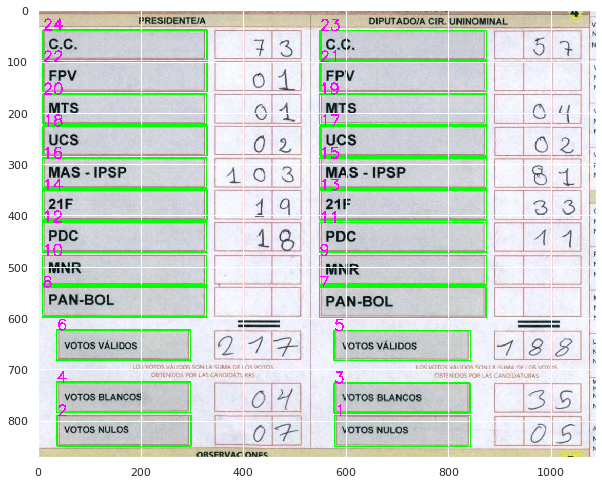

In [432]:
bads.append(counter)
counter +=1
plot_image()

In [776]:
bads

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186

In [208]:
gods = []

908
......
P: 49
A: 58
ID: 75489
LINK: 754891.jpg


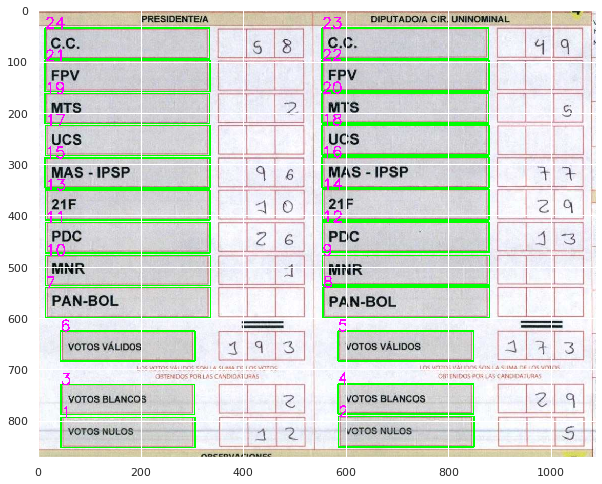

In [377]:
gods.append(counter)
counter +=1
plot_image()

In [777]:
gods

[48, 93, 331, 368, 374, 430, 433, 490, 569, 583]

In [257]:
93, 90194
81064

90194

In [ ]:
CORRECTIONS
368
374
404
430
433
466 # no  clear justification
489
490
569
583
618 
622
634
641
651
656
657
661
665 # bad suspisious
668 # bad suspisioous
669
670
673
676
717
725
735
735
765
819
820
821

826 # Counts not match
841 # Bad
852

878 # No huellas
890 
906
907

In [ ]:
# Bad houd

665

In [ ]:
# Copitas
630

In [ ]:
758 #bad

In [ ]:
# OOB
650

In [ ]:
# no sellos en trep, main number no coincide,  baSS
92, , 
331



In [79]:
df_predicted_bad.shape

(2958, 4)

In [80]:
bads = list(df_predicted_bad["Número Mesa"])

print(bads[:10])

[90388, 90387, 90386, 90385, 90384, 90383, 90382, 90379, 90378, 90377]


In [82]:
bads[2]

90386

In [ ]:
0, 1, 2, 3, 4, 5


In [104]:
np.unique(not_in_excel_counts)[:10]

array([182, 183, 184, 186, 187, 188, 189, 191, 193, 195])

Estos valores son los que no existen en el computo oficial

In [110]:
def check_flaw(flaw, df_pred):
    """
    Search in predicted dataframe the count flaw
    """
    return df_pred.loc[df_pred["counts"] == flaw]

In [114]:
f = float(not_in_excel_counts[0])
print(f)
flaw_df = check_flaw(f, df_cc)
flaw_df.head()

199.0


,id,counts,partidoid,mesa
9473,401341.jpg,199.0,23,40134
219724,746821.jpg,199.0,23,74682


In [117]:
bad_df_lists = []

for n in np.unique(not_in_excel_counts):
    flaw_df = check_flaw(n, df_cc)
    bad_df_lists.append(flaw_df)

df_bads = pd.concat(bad_df_lists, ignore_index=True)
df_bads.head()

,id,counts,partidoid,mesa
0,746021.jpg,182.0,23,74602
1,900601.jpg,182.0,23,90060
2,900361.jpg,182.0,23,90036
3,770401.jpg,182.0,23,77040
4,211261.jpg,182.0,23,21126


In [118]:
df_bads.shape

(79, 4)